# Vehicle Detection

## Import libs

In [1]:
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
from functools import partial
%matplotlib inline


## Get the images

In [2]:
import glob
cars=glob.glob("vehicles/*/*.png")
notcars=glob.glob("non-vehicles/*/*.png")
# read them as images
car_imgs = list(map(plt.imread, cars))
notcar_imgs = list(map(plt.imread, notcars))

# TODO: get the flipped images
flip = partial(cv2.flip,flipCode=1)
car_flipped = list(map(flip,car_imgs))
notcar_flipped = list(map(flip,notcar_imgs))

# # TODO: get the flipped notcar images
# Note: change this when dataset is changed
# vflip = partial(cv2.flip,flipCode=0)
# notcar_flipped += list(map(vflip,notcar_imgs))
# vhflip = partial(cv2.flip,flipCode=-1)
# notcar_flipped += list(map(vhflip,notcar_imgs))

cars = car_imgs+car_flipped
notcars = notcar_imgs+notcar_flipped

## Lesson functions

In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



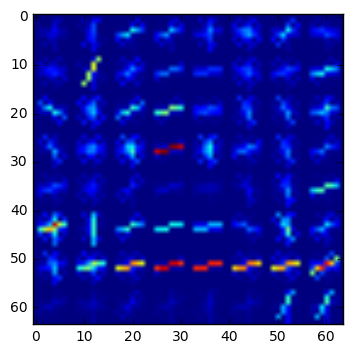

In [41]:
car_hog_f,car_hog = get_hog_features(cars[0][:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
plt.imshow(car_hog)

In [4]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        if isinstance(file,str):
            # Read in each one by one
            image = mpimg.imread(file)
        else:
            image = file
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Train a classifier

In [5]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

print("start feature extracting")

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("finish feature extracting")

start feature extracting
finish feature extracting


In [6]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [7]:
import time
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = 2017
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
35.6 Seconds to train SVC...
Test Accuracy of SVC =  0.9924


In [35]:
# dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
# svc = dist_pickle["svc"]
# X_scaler = dist_pickle["scaler"]
# orient = dist_pickle["orient"]
# pix_per_cell = dist_pickle["pix_per_cell"]
# cell_per_block = dist_pickle["cell_per_block"]
# spatial_size = dist_pickle["spatial_size"]
# hist_bins = dist_pickle["hist_bins"]

# img = mpimg.imread('test_image.jpg')
test_images = [plt.imread(img) for img in glob.glob("test_images/*.jpg")]
img = test_images[0]

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,plot=False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    preds = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                preds.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                if plot:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    plt.imshow(draw_img)
                    plt.show()
                
    return preds
    
ystart = 400
ystop = 656
scale = 1.5

# for img in test_images:
#     out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

#     plt.imshow(out_img)
#     plt.show()

## Heatmap

In [ ]:
'''get the heatmap according to the prediction'''
def heatmap(img,preds):
    hm = np.zeros(img.shape[:2])
    for start,end in preds:
        hm[start[1]:end[1],start[0]:end[0]]+=1
    return hm

'''# heatmap for duplication reduction'''
class LastNFrames(object):
    def __init__(self,n):
        self.queue=[]
        self.n=n
    def join(self,item):
        '''join the queue, and pop the first item if the queue is full'''
        self.queue.append(item)
        if len(self.queue)>self.n:
            self.queue.pop(0)
    def init_with_default(self,default):
        '''init the queue which fulfilled with default term'''
        self.queue=[default for i in range(self.n)]

def heatmap_generate(hm,lnf):
    '''valid the prediction in heatmap, to eliminate the false positives'''
    
    # join the pred
    lnf.join(hm)
    
    # get the result
    hm_total = np.zeros_like(hm)
    
    for hm_sub in lnf.queue:
        hm_total += hm_sub
        
    
    # normalize according to frames
    hm_total /= lnf.n
    
    return hm_total

## Generate video with heatmaps for testing

In [10]:
'''pipeline:test video generation'''
def process_image(img):
    global LNF
    
    output=np.copy(img)
    
    ystart = 400
    ystop = 656
    scale = 1.5
    global svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins
    
    preds = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    hm = heatmap(img,preds)
    
    hm_total = heatmap_generate(hm,LNF)
    
    output[0:360,640:1280,:] = cv2.resize((np.dstack((hm,hm,hm))*255),(640,360))
    
    output[0:360,0:640,:] = cv2.resize((np.dstack((hm_total,hm_total,hm_total))*255),(640,360))
    
    return output

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from datetime import datetime

In [12]:
# video generation
def video_generation(output_filename,sub1,sub2):
    global trial_i
    video_output = output_filename
    clip1 = VideoFileClip("project_video.mp4").subclip(sub1,sub2)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(video_output, audio=False)
    trial_i+=1
    return video_output

In [13]:
dtn=datetime.now()
trial_i = np.random.randint(0,100)
LNF=LastNFrames(10)
output_filename='trial %d %s.mp4'%(trial_i,datetime.now().strftime("%Y-%m-%d %H"))
video_generation(output_filename,0,40)

[MoviePy] >>>> Building video trial 52 2017-03-05 22.mp4
[MoviePy] Writing video trial 52 2017-03-05 22.mp4


100%|█████████▉| 1000/1001 [06:43<00:00,  2.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: trial 52 2017-03-05 22.mp4 

CPU times: user 6min 11s, sys: 40.9 s, total: 6min 52s
Wall time: 6min 43s


'trial 52 2017-03-05 22.mp4'

## Draw boxes on image to generate final video

In [27]:
from scipy.ndimage.measurements import label
def draw_labeled_bboxes(img, hm, threshold):
    # Iterate through all detected cars
    hm[hm <= threshold] = 0
    
    # if no car detected, return nothing
    if hm.sum() == 0:
        return img
    
    labels = label(hm)
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        # and threshold checking
        if (np.max(nonzerox)-np.min(nonzerox))>32 and (np.max(nonzerox)-np.min(nonzerox))<256 and (np.max(nonzeroy)-np.min(nonzeroy))>32 and (np.max(nonzeroy)-np.min(nonzeroy))<256:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [17]:
'''pipeline: final video generation'''
def process_image(img):
    global LNF,hm_threshold
    
    ystart = 400
    ystop = 656
    scale = 1.5
    global svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins
    
    preds = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    hm = heatmap(img,preds)
    
    hm_total = heatmap_generate(hm,LNF)
    
    output = draw_labeled_bboxes(img, hm_total, hm_threshold)
    
    return output

In [29]:
dtn=datetime.now()
trial_i = np.random.randint(0,100)
LNF=LastNFrames(10) # tune this
hm_threshold = 0.4 # tune this
output_filename='trial %d %s.mp4'%(trial_i,datetime.now().strftime("%Y-%m-%d %H"))
video_generation(output_filename,0,49)

[MoviePy] >>>> Building video trial 80 2017-03-05 23.mp4
[MoviePy] Writing video trial 80 2017-03-05 23.mp4




  0%|          | 0/1226 [00:00<?, ?it/s]

  0%|          | 1/1226 [00:00<08:26,  2.42it/s]

  0%|          | 2/1226 [00:00<08:12,  2.49it/s]

  0%|          | 3/1226 [00:01<08:00,  2.55it/s]

  0%|          | 4/1226 [00:01<08:12,  2.48it/s]

  0%|          | 5/1226 [00:01<08:11,  2.48it/s]

  0%|          | 6/1226 [00:02<08:00,  2.54it/s]

  1%|          | 7/1226 [00:02<07:51,  2.59it/s]

  1%|          | 8/1226 [00:03<07:44,  2.62it/s]

  1%|          | 9/1226 [00:03<07:39,  2.65it/s]

  1%|          | 10/1226 [00:03<07:47,  2.60it/s]

  1%|          | 11/1226 [00:04<08:11,  2.47it/s]

  1%|          | 12/1226 [00:04<08:06,  2.50it/s]

  1%|          | 13/1226 [00:05<07:54,  2.56it/s]

  1%|          | 14/1226 [00:05<07:42,  2.62it/s]

  1%|          | 15/1226 [00:05<07:41,  2.62it/s]

  1%|▏         | 16/1226 [00:06<07:35,  2.65it/s]

  1%|▏         | 17/1226 [00:06<07:32,  2.67it/s]

  1%|▏         | 18/1226 [00:06<07:43,  2.60it/s]

  2%|▏         | 19/1226 [00:07<07:47,  2.58it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: trial 80 2017-03-05 23.mp4 

CPU times: user 7min 18s, sys: 28 s, total: 7min 46s
Wall time: 7min 44s


'trial 80 2017-03-05 23.mp4'